In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("Cellular_uptake_REVISED_2.csv")
df = df[df['Incubation Time'] == 24]
df = df.drop(['Nanoparticle','Coating' ,'Study','Nominal Size (nm)', 'Medium type','Medium', 'Doi', 'Temperature (oC)','Imputation (Yes/No)', 'Imputed variables',
              'Cell line', 'Cell tissue', 'Method', 'Incubation Time', 'Method category', 'Penicillin/Streptomycin (Yes/No)','Cell species',
              'Cell category','FBS (%)', 'NP type'], axis=1)

# Define features and target
X = df.drop(columns=["Cell uptake"])
eps = 1e-10
y = np.log(df["Cell uptake"] + eps)  # log transformation

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_cols])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Drop original categorical columns and add encoded ones
X_cont = X.drop(columns=cat_cols).reset_index(drop=True)
X = pd.concat([X_cont, X_encoded_df], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Apply StandardScaler after splitting
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit on training data only
X_test_scaled = scaler_X.transform(X_test)  # Use the same parameters for test set

# Initialize XGBoost Regressor
xgb_model = XGBRegressor(random_state=1234)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [200],
    'max_depth': [4, 5],
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'reg_alpha': [0.1, 5],
    'reg_lambda': [5, 10],
    'min_child_weight': [1, 5]
}

# Use GridSearchCV to find the best parameters using cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the XGBoost model with the best parameters
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation to evaluate the model's performance
cv_scores = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=10, scoring='r2')

# Print out the cross-validation scores
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean Cross-validated R2: {cv_scores.mean()}")

# Make predictions on the test set (scaled)
y_pred = best_xgb_model.predict(X_test_scaled)

# Reverse log transformation
y_pred_original = np.exp(y_pred) - eps
y_test_original = np.exp(y_test) - eps

# Calculate metrics on the original scale
r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
rrmse = rmse / np.mean(y_test_original) * 100  # Relative RMSE in %

target_std = np.std(y_test_original)
target_range = np.max(y_test_original) - np.min(y_test_original)

normalized_rmse = rmse / target_range
normalized_mae = mae / target_std

# Calculate metrics on the transformed scale
r2_trans = r2_score(y_test, y_pred)
mae_trans = mean_absolute_error(y_test, y_pred)
mse_trans = mean_squared_error(y_test, y_pred)
rmse_trans = np.sqrt(mse_trans)

# Print final metrics transformed
print("\nMetrics on the transformed test set after training")
print(f"R²: {r2_trans:.6f}")
print(f"MAE: {mae_trans:.6f}")
print(f"MSE: {mse_trans:.6f}")
print(f"RMSE: {rmse_trans:.6f}")

# Print final metrics
print("\nMetrics on the original test set after training")
print(f"R²: {r2:.6f}")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"Relative RMSE: {rrmse:.2f}%")
print(f"Normalized RMSE (based on target range): {normalized_rmse:.6f}")
print(f"Normalized MAE (based on standard deviation): {normalized_mae:.6f}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.7}
Cross-validated R2 scores: [0.87091293 0.25043992 0.64115707 0.87545954 0.92157839 0.98084957
 0.69425104 0.80061764 0.94734087 0.84073227]
Mean Cross-validated R2: 0.7823339250410053

Metrics on the transformed test set after training
R²: 0.920812
MAE: 1.183726
MSE: 3.125029
RMSE: 1.767775

Metrics on the original test set after training
R²: 0.667628
MAE: 561689415.750374
MSE: 5613081757833999360.000000
RMSE: 2369194326.735146
Relative RMSE: 233.62%
Normalized RMSE (based on target range): 0.092353
Normalized MAE (based on standard deviation): 0.136681


In [ ]:
print(f"Number of rows (samples): {X_train.shape[0]}")
print(f"Number of columns (features): {X_train.shape[1]}")

Number of rows (samples): 226
Number of columns (features): 19


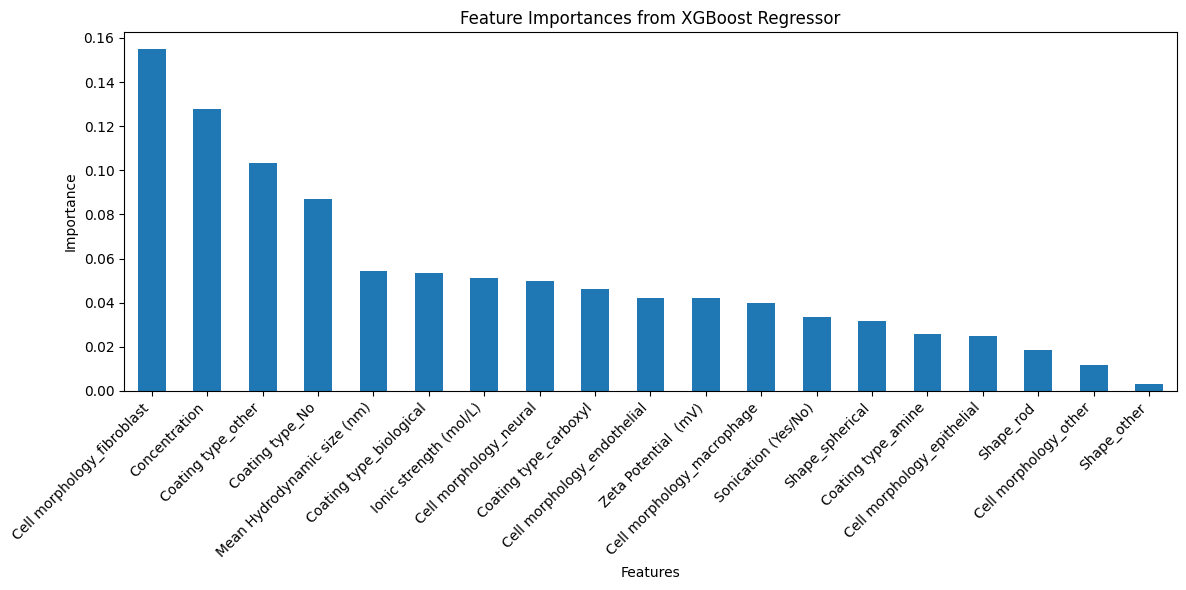

In [ ]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns)

# Sort the feature importances in descending order and plot
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6))
plt.title("Feature Importances from XGBoost Regressor")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # To prevent overlap of labels
plt.show()

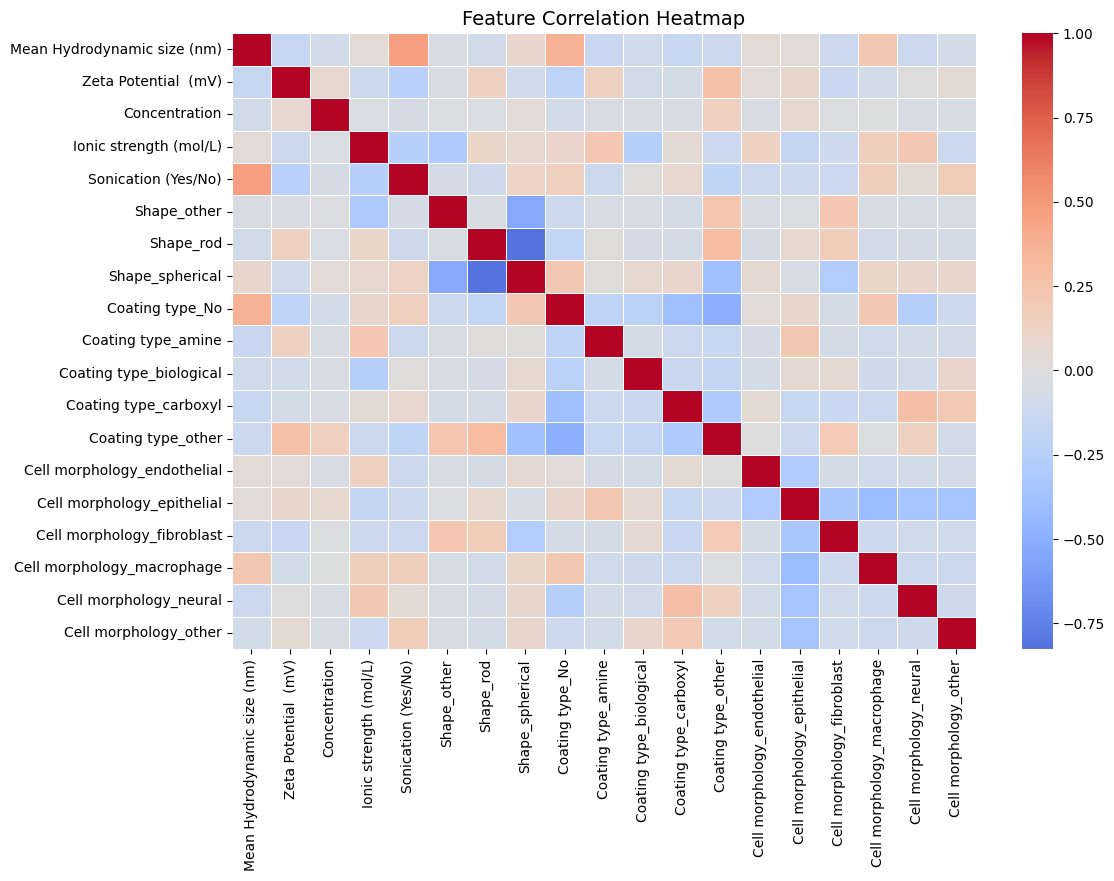

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = X.corr()

# Plot the heatmap with better visualization
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5, fmt=".2f")

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

<ipython-input-57-1551a11067b3>:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


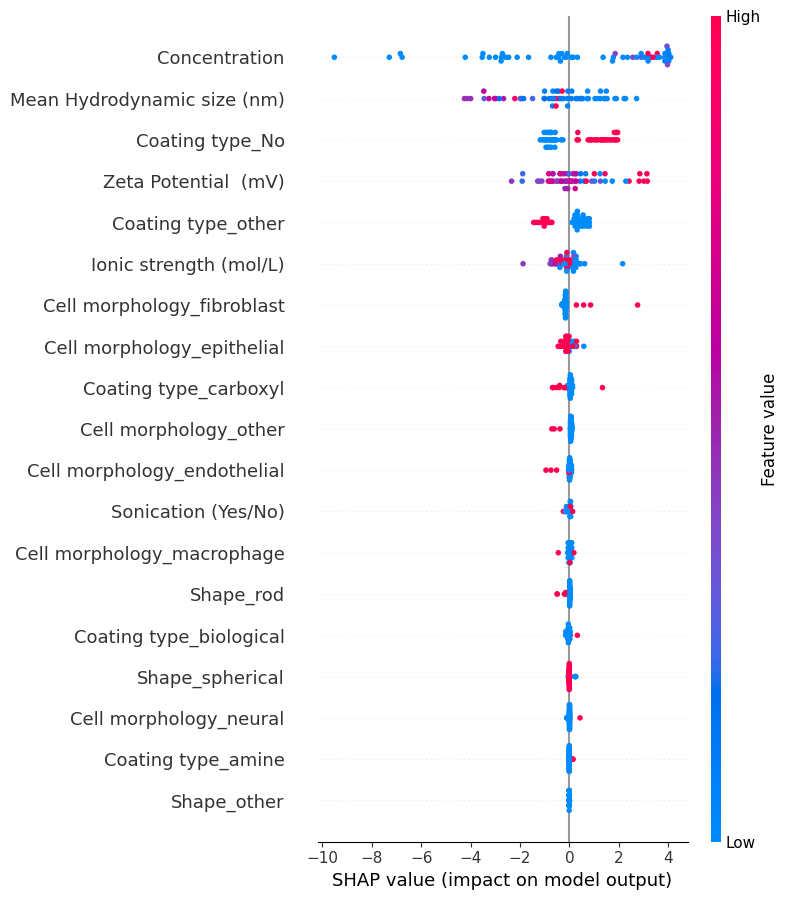

In [ ]:
import shap
import matplotlib.pyplot as plt

# Wrap the model so SHAP sees unscaled input but model gets scaled input
explainer = shap.Explainer(lambda x: best_xgb_model.predict(scaler_X.transform(x)), X_train)

# Compute SHAP values on unscaled test data
shap_values = explainer(X_test)

# Create summary plot with real feature names and values
shap.summary_plot(shap_values, X_test)

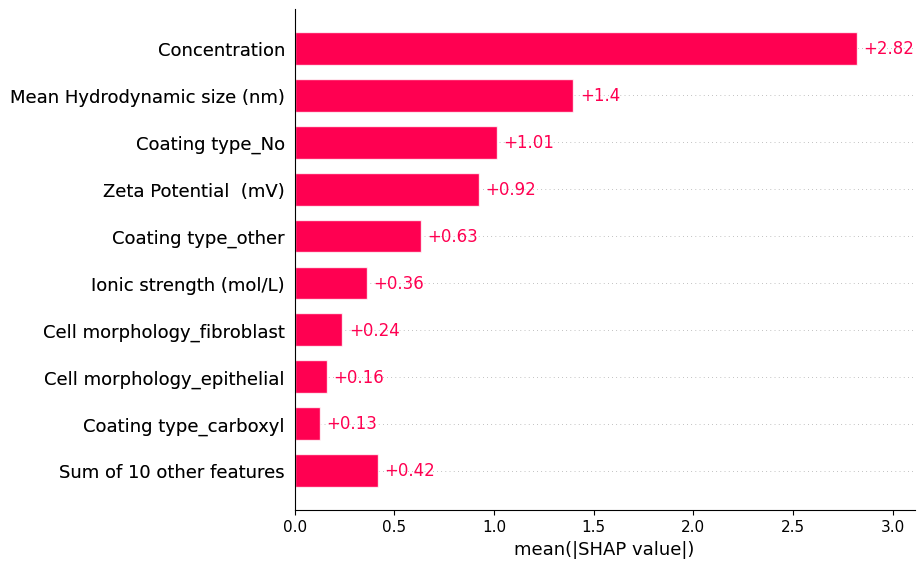

In [ ]:
shap.plots.bar(shap_values)

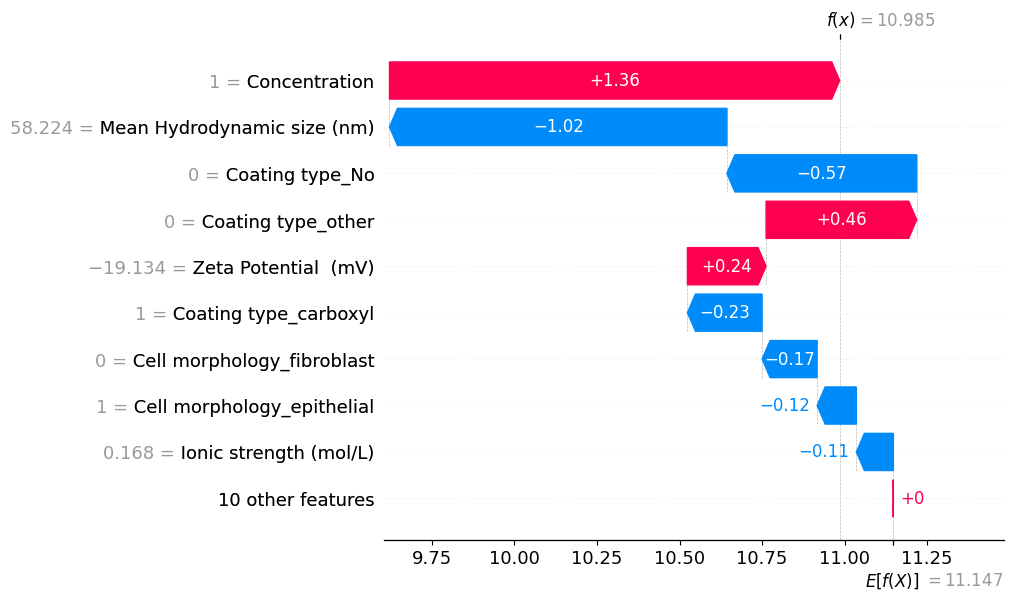

In [ ]:
# Waterfall plot for first test instance
shap.plots.waterfall(shap_values[3])

In [ ]:
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "SHAP Importance": np.abs(shap_values.values).mean(axis=0)
}).sort_values("SHAP Importance", ascending=False)

print(importance_df.head(10))  # Top 10 most influential features

                        Feature  SHAP Importance
2                 Concentration         2.820049
0   Mean Hydrodynamic size (nm)         1.397592
8               Coating type_No         1.013386
1          Zeta Potential  (mV)         0.922825
12           Coating type_other         0.632147
3        Ionic strength (mol/L)         0.362777
15   Cell morphology_fibroblast         0.239190
14   Cell morphology_epithelial         0.161130
11        Coating type_carboxyl         0.125069
18        Cell morphology_other         0.091105


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("Cellular_uptake_REVISED_2.csv")
df = df[df['Incubation Time'] == 24]
df = df.drop(['Nanoparticle','Coating' ,'Study','Nominal Size (nm)', 'Medium type','Medium', 'Doi', 'Temperature (oC)',
              'Imputation (Yes/No)', 'Imputed variables','Cell line', 'Cell tissue', 'Method', 'Incubation Time',
              'Method category', 'Penicillin/Streptomycin (Yes/No)','Cell species','Cell category','FBS (%)', 'NP type'], axis=1)

# Define features and target
eps = 1e-10
y = np.log(df["Cell uptake"] + eps)
X = df.drop(columns=["Cell uptake"])

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_cols])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Combine with continuous features
X_cont = X.drop(columns=cat_cols).reset_index(drop=True)
X = pd.concat([X_cont, X_encoded_df], axis=1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train original model
model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.7,
                     colsample_bytree=0.7, reg_alpha=0.1, reg_lambda=5, min_child_weight=1,
                     random_state=1234)
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)
r2_original = r2_score(np.exp(y_test), np.exp(y_pred))
print(f"Original Model R²: {r2_original:.6f}")

# === Y-RANDOMIZATION ===
print("\nShuffled Model R² scores (10 shuffles):")
for i in range(10):
    y_train_shuffled = y_train.sample(frac=1.0, random_state=i).reset_index(drop=True)  # Shuffle target
    model.fit(X_train_scaled, y_train_shuffled)
    y_pred_shuffled = model.predict(X_test_scaled)
    r2_shuffled = r2_score(np.exp(y_test), np.exp(y_pred_shuffled))
    print(f"Shuffle {i+1:2d}: R² = {r2_shuffled:.6f}")


Original Model R²: 0.667628

Shuffled Model R² scores (10 shuffles):
Shuffle  1: R² = -0.056902
Shuffle  2: R² = 0.037253
Shuffle  3: R² = 0.067255
Shuffle  4: R² = -5.495154
Shuffle  5: R² = -0.060871
Shuffle  6: R² = -0.060780
Shuffle  7: R² = -0.062072
Shuffle  8: R² = 0.021871
Shuffle  9: R² = -0.061027
Shuffle 10: R² = -0.060563


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def calculate_applicability_domain(X_train, X_test, k=5, threshold_percentile=95):
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(X_train)

    distances, _ = knn.kneighbors(X_test)
    avg_distances = distances.mean(axis=1)

    # Get the distance threshold from training data
    train_distances, _ = knn.kneighbors(X_train)
    train_avg_distances = train_distances.mean(axis=1)
    threshold = np.percentile(train_avg_distances, threshold_percentile)

    in_domain = avg_distances <= threshold
    return in_domain, avg_distances, threshold


In [ ]:
in_domain_flags, test_distances, ad_threshold = calculate_applicability_domain(X_train, X_test)

print(f"Applicability Domain Threshold (based on training data): {ad_threshold:.4f}")
print(f"Number of test samples: {len(X_test)}")
print(f"Number inside AD: {in_domain_flags.sum()}")
print(f"Number outside AD: {(~in_domain_flags).sum()}")


Applicability Domain Threshold (based on training data): 7446.2820
Number of test samples: 57
Number inside AD: 48
Number outside AD: 9
